In [4]:
# Earth Lab
# Ian Adler
# This notebook is for running a simple Spectral Angle Mapper algorithm on a hyperspectral data "cube".
# Currently this is for a specific image of a Tennis court, with the goal of isolating the court from it's
# surroundings using one reference tennis court pixel called our "endmember". With a more structured dataset,
# this code could be wrapped into a function and made to run on any cube using any endmember.

In [29]:
from spectral import open_image, msam
import pysptools.eea as eea #for extracting endmembers
from xarr_helpers import extract_from_NEON
import geopandas as gpd
import fiona
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np

import pysptools.util as util
import pysptools.eea as eea
import pysptools.abundance_maps as amp
from pysptools.classification import SAM
from earthpy.spatial import bytescale

In [30]:
# Import raw data and remove NaNs
dtype = "VNIR"
bin_path = '../headwall_data/Radiance/' + dtype + '_CUSouth/headwall_CUS_block0_' + dtype.lower() + '_rad_glt_cor.hdr'
data, header = util.load_ENVI_file(bin_path)
wavelengths = np.asarray(header['wavelength'])
hsi_cube = np.nan_to_num((data))
# data is MxNxWAVELENGTHS raw pixel values.

In [31]:
def get_vec(data, pos):
    # Return the vector at the position "pos" from source "data"
    return data[pos[0],pos[1],:]

# Extract our endmember, using the a manually determined tennis court pixel
em_pixel = (310, 100)
em = get_vec(hsi_cube, em_pixel)

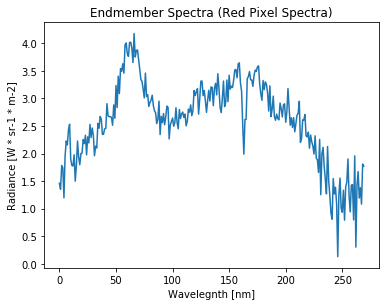

In [32]:
# Create figure object
fig = plt.figure()
ax1 = fig.add_subplot(211)
fig.subplots_adjust(top=2)

# Add axis Labels
ax1.set_ylabel('Radiance [W * sr-1 * m-2]')
ax1.set_xlabel('Wavelegnth [nm]')
ax1.set_title('Endmember Spectra (Red Pixel Spectra)')

# Plot the curve
line, = ax1.plot(em)

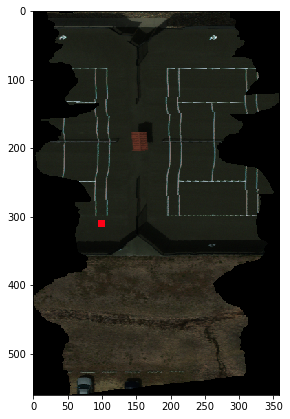

In [33]:
def show_rgb(input_img, focus_pixel = tuple()):
    # Display the RGB (or closest RGB equivalent) of a hyperspectral image cube
    fig = plt.figure(figsize=(20,8))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])
    ax1 = plt.subplot(gs[1])
    rgb_img = bytescale(input_img[:,:,[135, 72, 41]]) # 135, 72, 41 positions correspond roughly to R G B wavelengths
    
    # Add 10x10 marker where em pixel is, plot in RGB
    # This is a suboptimal solution. Also, no edge case safety measures.
    if (focus_pixel != ()):
        rgb_img[(focus_pixel[0]-5):(focus_pixel[0]+5),(focus_pixel[1]-5):(focus_pixel[1]+5),0] = 255 # red channel maxed
        rgb_img[(focus_pixel[0]-5):(focus_pixel[0]+5),(focus_pixel[1]-5):(focus_pixel[1]+5),1:2] = 2 # blue, green channel minimized
    
    ax1.imshow(rgb_img)

show_rgb(hsi_cube, em_pixel)

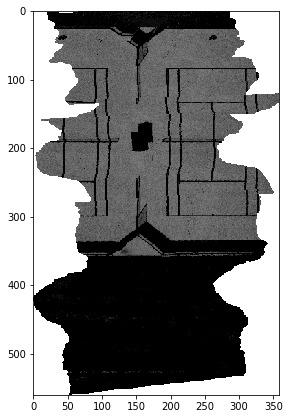

In [34]:
# https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
def angle_between(v1, v2):
    # returns angle in radians
    v1_u = v1 / np.linalg.norm(v1)
    v2_u = v2 / np.linalg.norm(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# Run the SAM by dotting every pixel of the hsi cube with the endmember.
rad_map = np.zeros((hsi_cube.shape[0], hsi_cube.shape[1]))
for row in range(hsi_cube.shape[0]): # list comprehension would speed this up
    for col in range(hsi_cube.shape[1]):
        theta = np.clip(np.nan_to_num(angle_between(hsi_cube[row,col,:], em)), 0, 0.2)
        rad_map[row,col] = theta

# Plot the resulting image
scaled_map = bytescale(rad_map)
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])
ax1 = plt.subplot(gs[1])
tmp = ax1.imshow(scaled_map, cmap = "gray_r")

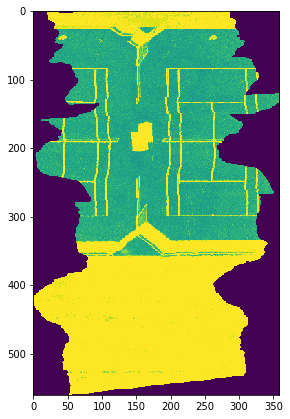

In [35]:
# Another way to plot
scaled_map = bytescale(rad_map)
fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 1])
ax1 = plt.subplot(gs[1])
tmp = ax1.imshow(scaled_map)